In [35]:
import os
import pandas as pd
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
import matplotlib.pyplot as plt


DATAPATH = "../data/combine_mols"

In [88]:
#get the smiles discarding any that have less than 100 MW
lab_data = ["Cook's group csv.csv", "Dickman's group CSV.csv", "G25 alcohol containing Cmpds.csv", "Lab218 csv.csv"]
smiles= []
for d in lab_data:
    df = pd.read_csv(os.path.join(DATAPATH, "lab_available", d))
    print(df.shape)
    df = df[df["Molecular Weight"]>100]
    smi = df["SMILES"].tolist()
    print(len(smi))
    smiles += smi

(16, 15)
9
(74, 15)
60
(111, 15)
90
(53, 15)
34


In [89]:
#make sure all molecules contain an alcohol group
def has_alcohol_group(molecule):
    mol = Chem.MolFromSmiles(molecule)
    if mol is not None:
        # Check if the molecule contains an alcohol group
        for atom in mol.GetAtoms():
            if atom.GetAtomicNum() == 8 and atom.GetTotalNumHs() == 1:
                return True
    return False

def filter_molecules_with_alcohol(molecule_list):
    filtered_molecules = [mol for mol in molecule_list if has_alcohol_group(mol)]
    return filtered_molecules

filtered_smiles = filter_molecules_with_alcohol(smiles)
print(len(filtered_smiles))

193


In [90]:
#for simplicity we will only combine molecules that have one alcohol group, not more
def count_alcohol_groups(molecule):
    mol = Chem.MolFromSmiles(molecule)
    if mol is not None:
        # Count the number of alcohol groups in the molecule
        alcohol_count = sum(1 for atom in mol.GetAtoms() if atom.GetAtomicNum() == 8 and atom.GetTotalNumHs() == 1)
        return alcohol_count
    return 0

def filter_molecules_with_one_alcohol(molecule_list):
    filtered_molecules = [mol for mol in molecule_list if count_alcohol_groups(mol) == 1]
    return filtered_molecules

filtered_smiles = filter_molecules_with_one_alcohol(filtered_smiles)
print(len(filtered_smiles))

137


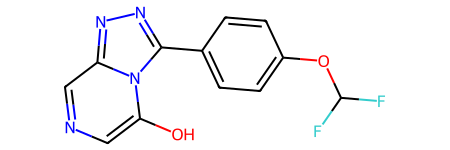

In [91]:
scaffold = "OC1=CN=CC2=NN=C(N12)C1=CC=C(OC(F)F)C=C1"
mol = Chem.MolFromSmiles(scaffold)
mol

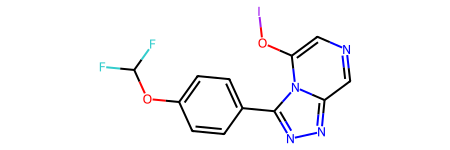

In [92]:
scaffold_dummy = "FC(F)OC1=CC=C(C=C1)C1=NN=C2C=NC=C(OI)N12" #contains an extra I for the join
mol = Chem.MolFromSmiles(scaffold_dummy)
mol

In [93]:
# Replace OH group by I in the fragments to allow the joining

def replace_oh_with_i(molecule_list):
    modified_molecules = []
    for smi in molecule_list:
        mol = Chem.MolFromSmiles(smi)
        if mol is not None:
            # Find the atom indices of the -OH group
            oh_atom_indices = [atom.GetIdx() for atom in mol.GetAtoms() if atom.GetSymbol() == 'O' and atom.GetTotalNumHs() == 1]

            # Replace -OH with I
            for oh_index in oh_atom_indices:
                mol.GetAtomWithIdx(oh_index).SetAtomicNum(53)  # 53 is the atomic number for iodine

            # Convert the modified molecule to SMILES notation
            modified_smi = Chem.MolToSmiles(mol)
            modified_molecules.append(modified_smi)

    return modified_molecules

dummy_frags = replace_oh_with_i(filtered_smiles)

In [94]:
from CombineMols.CombineMols import CombineMols

combined_smiles = []

for dummy_frag in dummy_frags:
    mol1 = Chem.MolFromSmiles(scaffold_dummy)
    mol2 = Chem.MolFromSmiles(dummy_frag)
    m = CombineMols(mol1, mol2, "I")
    smi = Chem.MolToSmiles(m[0])
    combined_smiles += [smi]

print(len(combined_smiles))

In [98]:
#save the file to manually check if the joining is correct before running predictions
df = pd.DataFrame({"fragment": filtered_smiles, "dummy": dummy_frags, "smiles":combined_smiles})
df.to_csv(os.path.join(DATAPATH, "combined_mols.csv"), index=False)

# Compare the predictions of activity

We will compare three Ersilia models and one external model:
* eos7yti (models built with OSM data, cut-offs 1 and 2.5 uM)
* eos4rta (model built with MMV data)
* MAIP (original maip server)

In [3]:
eos7yti = {"combined": pd.read_csv(os.path.join(DATAPATH, "predictions", "combined_mols_eos7yti_predictions.csv")),
           "sampled": pd.read_csv(os.path.join(DATAPATH, "predictions", "sampled_eos7yti_predictions.csv"))
           }

eos4rta = {"combined": pd.read_csv(os.path.join(DATAPATH, "predictions", "combined_mols_eos4rta_predictions.csv")),
           "sampled": pd.read_csv(os.path.join(DATAPATH, "predictions", "sampled_eos4rta_predictions.csv"))
           }

maip = {"combined": pd.read_csv(os.path.join(DATAPATH, "predictions", "combined_mols_maip_predictions.csv")),
        "sampled": pd.read_csv(os.path.join(DATAPATH, "predictions", "sampled_maip_predictions.csv"))
           }

(array([116.,   7.,   2.,   2.,   0.,   0.,   1.,   1.,   1.,   7.]),
 array([4.13634670e-07, 9.98759063e-02, 1.99751399e-01, 2.99626892e-01,
        3.99502384e-01, 4.99377877e-01, 5.99253369e-01, 6.99128862e-01,
        7.99004355e-01, 8.98879847e-01, 9.98755340e-01]),
 <BarContainer object of 10 artists>)

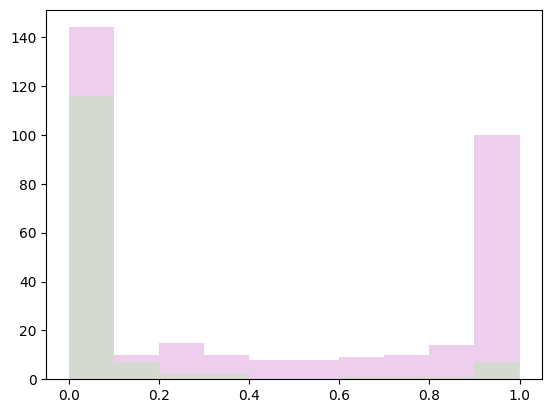

In [9]:

plt.hist(eos7yti["sampled"]["IC50_1uM"], color = "#dca0dc", alpha=0.5)
plt.hist(eos7yti["combined"]["IC50_1uM"], color = "#bee6b4", alpha = 0.5)

(array([70., 12.,  9.,  8.,  5.,  4.,  5.,  5.,  8., 11.]),
 array([2.26222010e-04, 9.27420158e-02, 1.85257810e-01, 2.77773603e-01,
        3.70289397e-01, 4.62805191e-01, 5.55320985e-01, 6.47836779e-01,
        7.40352572e-01, 8.32868366e-01, 9.25384160e-01]),
 <BarContainer object of 10 artists>)

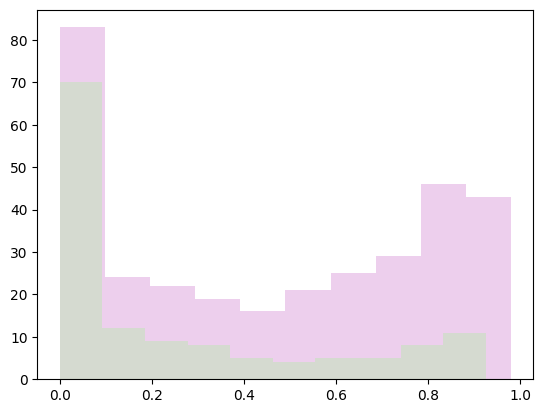

In [12]:
plt.hist(eos7yti["sampled"]["IC50_2.5uM"], color = "#dca0dc", alpha=0.5)
plt.hist(eos7yti["combined"]["IC50_2.5uM"], color = "#bee6b4", alpha = 0.5)

(array([12., 24., 31., 31., 20.,  3.,  7.,  5.,  1.,  3.]),
 array([0.23153286, 0.25189552, 0.27225819, 0.29262085, 0.31298352,
        0.33334618, 0.35370884, 0.37407151, 0.39443417, 0.41479684,
        0.4351595 ]),
 <BarContainer object of 10 artists>)

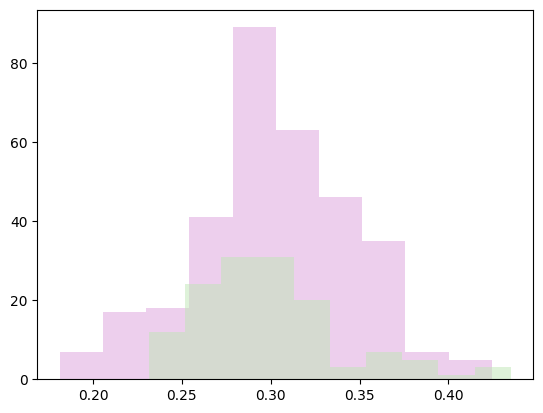

In [15]:
plt.hist(eos4rta["sampled"]["NF54_IC50_72h_1uM"], color = "#dca0dc", alpha=0.5)
plt.hist(eos4rta["combined"]["NF54_IC50_72h_1uM"], color = "#bee6b4", alpha = 0.5)

(array([70., 33., 15.,  4.,  9.,  0.,  4.,  0.,  1.,  1.]),
 array([0.06978098, 0.11079725, 0.15181353, 0.1928298 , 0.23384608,
        0.27486235, 0.31587862, 0.3568949 , 0.39791117, 0.43892745,
        0.47994372]),
 <BarContainer object of 10 artists>)

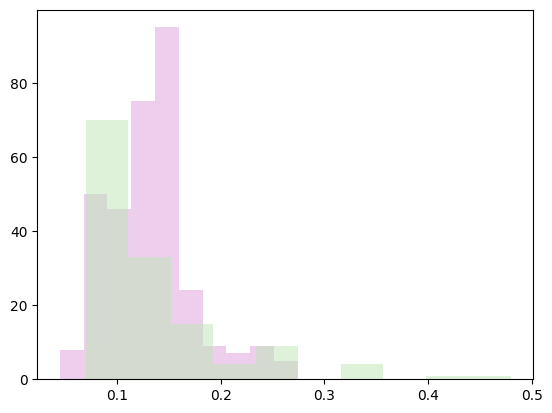

In [17]:
plt.hist(eos4rta["sampled"]["NF54_50PercInh_LUM"], color = "#dca0dc", alpha=0.5)
plt.hist(eos4rta["combined"]["NF54_50PercInh_LUM"], color = "#bee6b4", alpha = 0.5)

(array([15., 11., 17., 32., 29., 11.,  9.,  2.,  7.,  4.]),
 array([0.0263655 , 0.05712176, 0.08787802, 0.11863428, 0.14939054,
        0.1801468 , 0.21090306, 0.24165932, 0.27241558, 0.30317184,
        0.3339281 ]),
 <BarContainer object of 10 artists>)

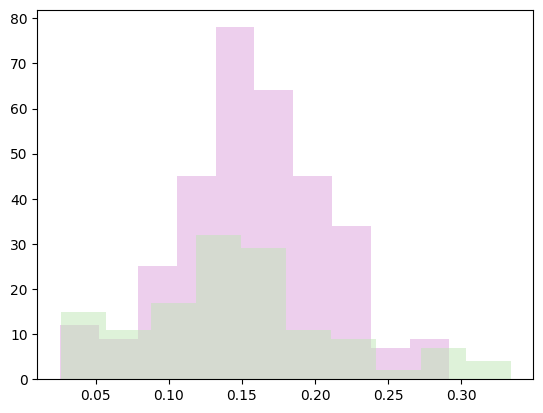

In [18]:
plt.hist(eos4rta["sampled"]["NF54_50PercInh_LDH"], color = "#dca0dc", alpha=0.5)
plt.hist(eos4rta["combined"]["NF54_50PercInh_LDH"], color = "#bee6b4", alpha = 0.5)

(array([ 3., 42., 39., 33., 17.,  0.,  0.,  0.,  0.,  1.]),
 array([13.58227178, 20.68288942, 27.78350705, 34.88412469, 41.98474232,
        49.08535995, 56.18597759, 63.28659522, 70.38721285, 77.48783049,
        84.58844812]),
 <BarContainer object of 10 artists>)

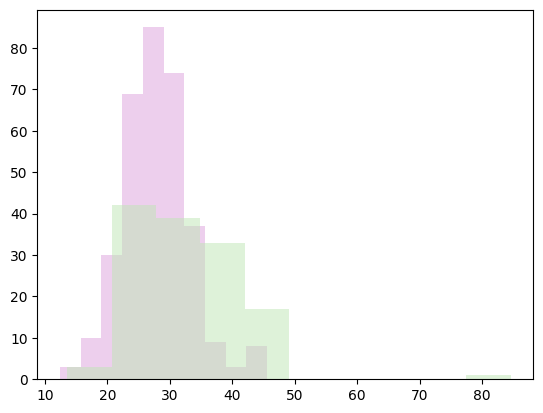

In [20]:
plt.hist(maip["sampled"]["model_score"], color = "#dca0dc", alpha=0.5)
plt.hist(maip["combined"]["model_score"], color = "#bee6b4", alpha = 0.5)

In [27]:
#comparison

comb = pd.read_csv(os.path.join(DATAPATH, "predictions", "combined_mols_predictions.csv"))
sel = pd.read_csv(os.path.join(DATAPATH, "predictions", "sampled_selected_predictions.csv"))

In [37]:
#filter out for the same values (IC50 2.5 uM less than 0.5, T > 0.5)
print(comb.shape)
comb_ = comb[comb["IC50_2.5uM"]>= 0.5]
print(comb_.shape)
comb_ = comb_[comb_["T12"]<0.5]
print(comb_.shape)

(137, 96)
(31, 96)
(29, 96)


In [43]:
comb_ = comb_[comb_["IC50_1uM"]>=0.5]
smiles = list(set(comb_["SMILES"].tolist()))

In [45]:
df = pd.DataFrame({"smiles":smiles})
df.to_csv(os.path.join(DATAPATH, "combined_mols_selected.csv"), index=False)